In [9]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import xarray as xr
import numpy as np
import admix
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans

import dask
import dask.array as da
from tqdm import tqdm

from admix.data import quantile_normalize
import pickle
import sys

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sys.path.append("../../")
import common

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [48]:
dict_trait_display_name

{'crp': 'C-reactive protein',
 'total_wbc_cnt': 'White blood cell count',
 'mean_corp_hgb_conc': 'MCHC',
 'platelet_cnt': 'Platelet count',
 'hdl': 'HDL',
 'ldl': 'LDL',
 'triglycerides': 'Triglycerides',
 'total_cholesterol': 'Total cholesterol',
 'cigs_per_day_excl_nonsmk_updated': 'Cigarettes per day',
 'coffee_cup_day': 'Coffee consumption',
 'a1c': 'HbA$_\\text{1c}$',
 'insulin': 'Fasting insulin',
 'glucose': 'Fasting glucose',
 't2d_status': 'Type 2 diabetes',
 'qt_interval': 'QT interval',
 'qrs_interval': 'QRS interval',
 'pr_interval': 'PR interval',
 'systolic_bp': 'Systolic blood pressure',
 'diastolic_bp': 'Diastolic blood pressure',
 'hypertension': 'Hypertension',
 'waist_hip_ratio': 'WHR',
 'height': 'Height',
 'bmi': 'BMI',
 'egfrckdepi': 'eGFR'}

In [97]:
SUPP_TABLE_URL = "supp_tables.xlsx"
trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="trait-info")
trait_list = trait_info["trait"].values
dict_trait_display_name = {
    row["trait"]: row["display-name"] for _, row in trait_info.iterrows()
}
dict_trait_display_name["a1c"] = r"HbA$\mathregular{_{1c}}$"

dict_trait_category = {row.trait: row.category for _, row in trait_info.iterrows()}

In [118]:
df_summary = {
    "trait": [],
    "n_indiv": [],
    "sigma_g": [],
    "rho_g": [],
    "sigma_e": [],
    "rg": [],
}

df_plot = {"trait": [], "n_indiv": [], "rg": [], "rg_stderr": []}

for trait in trait_list:
    with open(f"out/estimate/trait_{trait}.pkl", "rb") as f:
        rls = pickle.load(f)

    # fill in for summary
    df_summary["trait"].append(rls["trait"])
    df_summary["n_indiv"].append(rls["n_indiv"])

    for i, name in enumerate(["sigma_g", "rho_g", "sigma_e"]):
        df_summary[name].append(
            f"{rls['est'][i]:.2f} ({np.sqrt(rls['est_var'][i, i]):.2f})"
        )
    df_summary["rg"].append(f"{rls['rg']:.2f} ({np.sqrt(rls['rg_var']):.2f})")

    # fill in data for plotting
    df_plot["trait"].append(rls["trait"])
    df_plot["n_indiv"].append(rls["n_indiv"])
    df_plot["rg"].append(rls["rg"])
    df_plot["rg_stderr"].append(np.sqrt(rls["rg_var"]))


df_summary = pd.DataFrame(df_summary)
df_plot = pd.DataFrame(df_plot)
df_plot["pval"] = stats.norm.cdf((df_plot["rg"] - 1) / df_plot["rg_stderr"])
df_plot["category"] = [dict_trait_category[trait] for trait in trait_info["trait"]]
df_plot["category"] = df_plot["category"].astype("category")

df_plot = df_plot.sort_values("rg")

<ipython-input-136-ec4faf6543e3>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


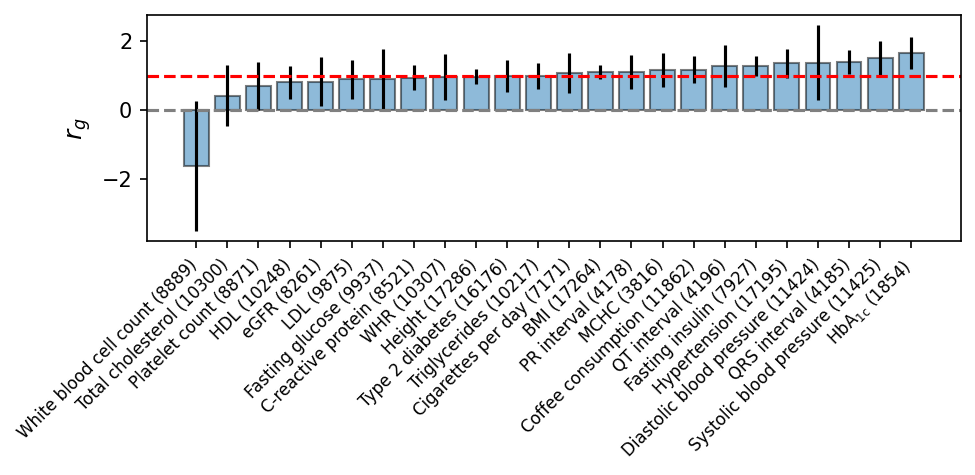

In [136]:
cmap = sns.color_palette("tab10")
fig, ax = plt.subplots(figsize=(7, 2), dpi=150)

ax.bar(
    df_plot["trait"],
    df_plot["rg"],
    yerr=df_plot["rg_stderr"] * 2,
    align="center",
    alpha=0.5,
    ecolor="black",
    edgecolor="black",
    capsize=0,
)

display_name = [
    f"{dict_trait_display_name[row.trait]} ({row.n_indiv})"
    for _, row in df_plot.iterrows()
]
ax.set_xticklabels(
    display_name,
    rotation=45,
    va="top",
    ha="right",
    fontsize=8,
)

ax.axhline(y=1.0, ls="--", color="r")
ax.axhline(y=0.0, ls="--", color="gray")
trans = mtrans.Affine2D().translate(5, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)

ax.set_ylabel("$r_g$", fontsize=12)
fig.show()
# plt.tight_layout()
plt.savefig("results/overview.pdf", bbox_inches="tight")